In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.read_csv('dataset/output.csv')

df['lat']=(df['lat']-df['lat'].min())/(df['lat'].max()-df['lat'].min())
df['lng']=(df['lng']-df['lng'].min())/(df['lng'].max()-df['lng'].min())
df['Transactions']=(df['Transactions']-df['Transactions'].min())/(df['Transactions'].max()-df['Transactions'].min())

event_dictionary ={'Condominium' : "High Rise", 'Flat' : "High Rise"}
conditions = [(df['Condominium'] == 1),(df['Flat'] == 1)]
choices = ['HighRise', 'HighRise']
df['Type'] = np.select(conditions, choices, default='Landed')

df["Tenure"].replace({"FREEHOLD": 1, "LEASEHOLD": 0}, inplace=True)
df["Type"].replace({"HighRise": 0, "Landed": 1}, inplace=True)
df["Township"].replace({"SEBERANG_PERAI_UTARA": 0, "SEBERANG_PERAI_TENGAH": 1, "SEBERANG_PERAI_SELATAN": 2, "BARAT_DAYA": 3, "TIMUR_LAUT": 4}, inplace=True)

df['Tenure'] = df['Tenure'].fillna(1)
df = df.drop(['Bungalow', 'ClusterHouse', 'SemiDetached', 'TerracedHouse', 'Condominium', 'Flat', 'Hostel', 'TownHouse'], axis = 1)

df.astype('int32').dtypes
df.head(5)

,Tenure,Sqft,Price,Transactions,Township,lat,lng,Type
0,1.00,312.34,765000.00,0.00,3,0.08,0.99,1
1,1.00,443.46,883440.00,0.01,3,0.08,0.99,0
2,1.00,427.70,519000.00,0.00,2,0.08,0.99,1
3,1.00,426.96,470500.00,0.00,2,0.08,0.99,1
4,1.00,295.27,838800.00,0.00,2,0.08,0.99,1


In [3]:
from scipy import stats
import numpy as np
z_scores = np.abs(stats.zscore(df['lng']))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
df = df[filtered_entries]

z_scores = np.abs(stats.zscore(df['lat']))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
df_new = df[filtered_entries]

df_new.head(5)

,Tenure,Sqft,Price,Transactions,Township,lat,lng,Type
0,1.00,312.34,765000.00,0.00,3,0.08,0.99,1
1,1.00,443.46,883440.00,0.01,3,0.08,0.99,0
2,1.00,427.70,519000.00,0.00,2,0.08,0.99,1
3,1.00,426.96,470500.00,0.00,2,0.08,0.99,1
4,1.00,295.27,838800.00,0.00,2,0.08,0.99,1


,Tenure,Sqft,Price,Transactions,Township,lat,lng,Type
0,1.00,312.34,765000.00,0.00,3,0.08,0.99,1
1,1.00,443.46,883440.00,0.01,3,0.08,0.99,0
2,1.00,427.70,519000.00,0.00,2,0.08,0.99,1
3,1.00,426.96,470500.00,0.00,2,0.08,0.99,1
4,1.00,295.27,838800.00,0.00,2,0.08,0.99,1


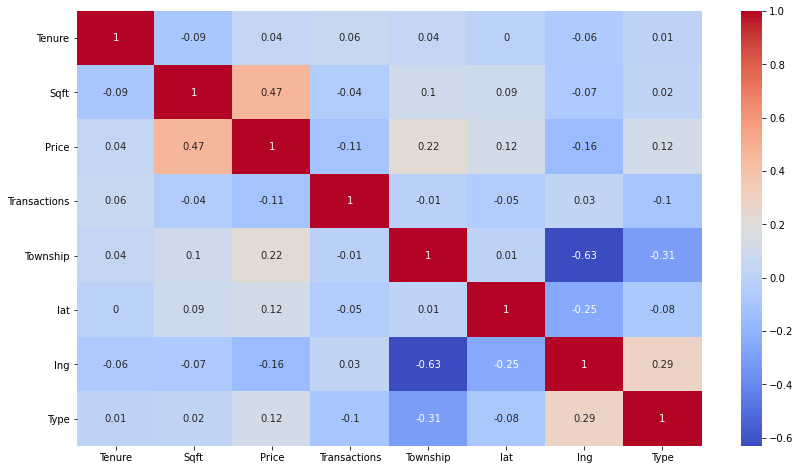

In [5]:
import seaborn as sns
# Plot the correlation heatmap
plt.figure(figsize=(14, 8))
corr_matrix = df_new.corr().round(2)
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True)
df_new.head(5)
# ideally need to select those features that are highly correlated with our dependent variable (Price)

In [6]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
y = np.array(df_new['Price'])
X = df_new.drop('Price', axis = 1)

train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [7]:
from numpy import absolute, mean, std
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

reg = LinearRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=24)
scores = (-cross_val_score(reg, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1))
print('RMSE: %.2f (%.2f)' % (mean(scores), std(scores)))

reg.fit(train_features,train_labels)
r2 = reg.score(test_features,test_labels) # residual sum of squares ((y_true - y_pred)** 2)
print('R2:', r2)

RMSE: 907473.07 (581700.30)
R2: 0.4928138368339251


In [8]:
from sklearn import ensemble

clf = ensemble.GradientBoostingRegressor(n_estimators = 500, max_depth = 4, min_samples_split = 2,
          learning_rate = 0.01, loss = 'ls')
scores = (-cross_val_score(clf, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1))
print('RMSE: %.2f (%.2f)' % (mean(scores), std(scores)))

clf.fit(train_features, train_labels)
r2 = (clf.score(test_features,test_labels))
print('R2:', r2)

RMSE: 722772.12 (447752.15)
R2: 0.7859395996220426


In [9]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth = 4)
scores = (-cross_val_score(dt, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1))
print('RMSE: %.2f (%.2f)' % (mean(scores), std(scores)))

dt.fit(train_features, train_labels)
r2 = (dt.score(test_features,test_labels))
print('R2:', r2)

RMSE: 691619.59 (450594.51)
R2: 0.8036270409246673


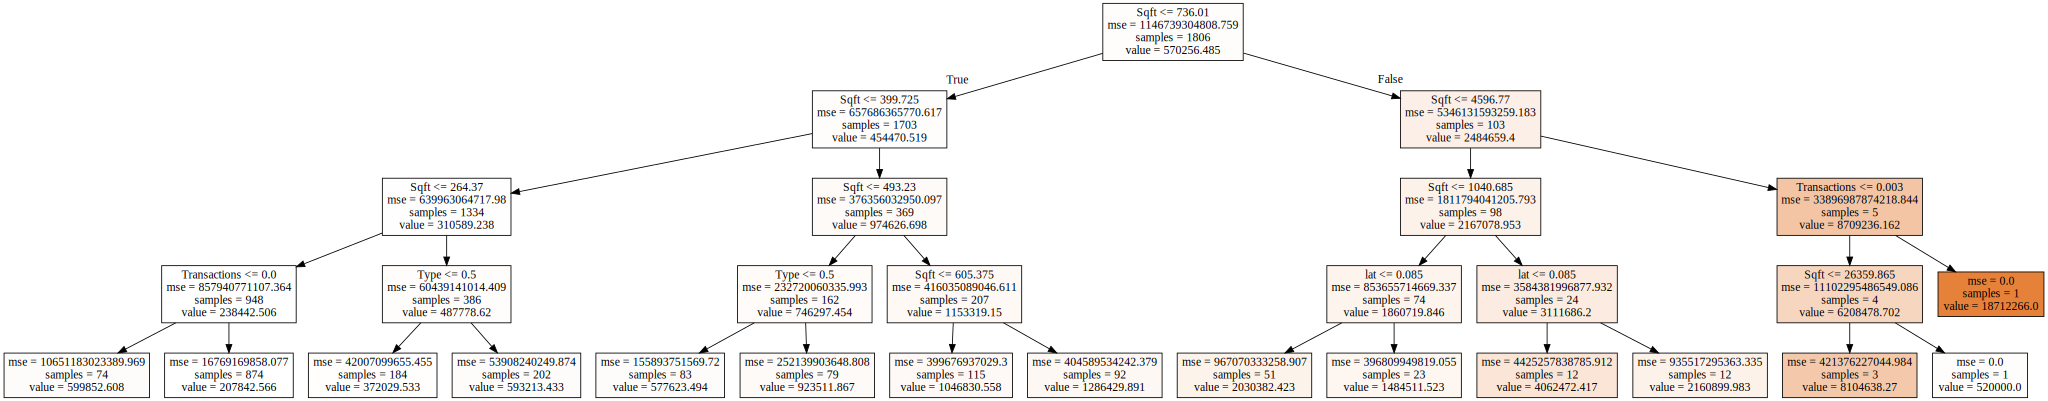

In [10]:
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=train_features.columns,  
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 500, max_depth = 4, random_state = 42)
scores = (-cross_val_score(rf, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1))
print('RMSE: %.2f (%.2f)' % (mean(scores), std(scores)))

rf.fit(train_features, train_labels)
r2 = (rf.score(test_features,test_labels))
print('R2:', r2)

RMSE: 691026.66 (442002.55)
R2: 0.7394717625488705


<AxesSubplot:>

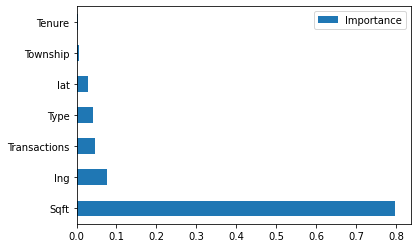

In [12]:
def feat_importance(m,df_train):
    importance = m.feature_importances_
    importance = pd.DataFrame(importance,index=df_train.columns,columns=["Importance"])
    return importance.sort_values(by=['Importance'],ascending=False)

importance = feat_importance(rf, X)
importance.plot(kind='barh')

In [18]:
#Discarding features with feature coefficients less than 0.01
to_keep = importance[importance['Importance'] > 0.01].index
train_features_keep = train_features[to_keep].copy()
test_features_keep = test_features[to_keep].copy()


# random forest
rf.fit(train_features_keep, train_labels)
print("RF R2: ", rf.score(test_features_keep,test_labels))

predictions = rf.predict(test_features_keep)
out_pred = pd.DataFrame({"actual":test_labels,"pred_rf":predictions})

# graident boost
clf.fit(train_features_keep, train_labels)
print("CLF R2: ", clf.score(test_features_keep,test_labels))

predictions = clf.predict(test_features_keep)
out_pred["pred_clf"] = predictions

# decision tree
dt.fit(train_features_keep, train_labels)
print("DT R2: ", dt.score(test_features_keep,test_labels))

predictions = dt.predict(test_features_keep)
out_pred["pred_dt"] = predictions

out_pred.to_csv("out_pred.csv")

RF R2:  0.739999527950316
CLF R2:  0.7946882757670668
DT R2:  0.8036270409246673
